In [1]:
import tensorflow as tf
print("TF Version:", tf.__version__)
import tensorflow_hub as hub
print("TF hub Version:", hub.__version__)
print("GPU", "availabe" if tf.config.list_physical_devices("GPU") else "not availabe")

TF Version: 2.6.0
TF hub Version: 0.12.0
GPU availabe


In [2]:
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

In [3]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 2849599174463301416, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 14512029696
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 17011795852458812201
 physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"]

In [6]:
import os
import numpy as np
np.random.seed(777)

import keras
import keras.backend as K
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam, SGD, RMSprop

from keras.models import Model

from keras.layers import Input, Activation, merge, Dense, Flatten, Dropout
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.layers import BatchNormalization, add, GlobalAveragePooling2D
from keras.applications.inception_v3 import InceptionV3


from keras.utils.vis_utils import plot_model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import load_model

from keras.utils import np_utils

from keras.regularizers import l2

import matplotlib.pyplot as plt
%matplotlib inline

In [8]:
train_dir = '/content/drive/MyDrive/Tea Omdena/Withered Raw v.1 80-20/Train'
test_dir = '/content/drive/MyDrive/Tea Omdena/Withered Raw v.1 80-20/Test'

In [12]:
for root,dirs,files in os.walk(train_dir):
    print (root, len(files))
print("-"*75)
for root,dirs,files in os.walk(test_dir):
    print (root, len(files))

/content/drive/MyDrive/Tea Omdena/Withered Raw v.1 80-20/Train 0
/content/drive/MyDrive/Tea Omdena/Withered Raw v.1 80-20/Train/Poor 218
/content/drive/MyDrive/Tea Omdena/Withered Raw v.1 80-20/Train/Below Best 224
/content/drive/MyDrive/Tea Omdena/Withered Raw v.1 80-20/Train/Best 215
---------------------------------------------------------------------------
/content/drive/MyDrive/Tea Omdena/Withered Raw v.1 80-20/Test 0
/content/drive/MyDrive/Tea Omdena/Withered Raw v.1 80-20/Test/Best 54
/content/drive/MyDrive/Tea Omdena/Withered Raw v.1 80-20/Test/Below Best 55
/content/drive/MyDrive/Tea Omdena/Withered Raw v.1 80-20/Test/Poor 55


In [15]:
output_classes = 3
batch_size = 16
img_height, img_width = 224,224
input_shape = (img_height, img_width, 3)
epochs = 20
nb_train_samples =657
nb_test_samples =164

In [16]:
random_seed = np.random.seed(1142)
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    featurewise_center=True,
    featurewise_std_normalization=True)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    seed = random_seed,
    shuffle = True,
    class_mode='categorical')


test_datagen = ImageDataGenerator(rescale=1. / 255)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    seed = random_seed,
    shuffle = False,
    class_mode='categorical')

Found 657 images belonging to 3 classes.
Found 164 images belonging to 3 classes.


## **InceptionV3**

In [18]:
adam_opt = Adam(lr=1e-5, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=1e-5)
from keras.models import Sequential
model = Sequential()

model.add(InceptionV3(weights = "imagenet", include_top=False, pooling = 'avg'))
model.add(Dropout(rate=0.5))
model.add(Dense(units=output_classes, activation='softmax'))

model.layers[0].trainable = True

87924736/87910968 [==============================] - 1s 0us/step


In [19]:
model.compile(optimizer= adam_opt,
              loss = 'categorical_crossentropy',
              metrics=['accuracy'])
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 2048)              21802784  
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 3)                 6147      
Total params: 21,808,931
Trainable params: 21,774,499
Non-trainable params: 34,432
_________________________________________________________________


In [20]:
history = model.fit_generator(
  train_generator,
  steps_per_epoch = nb_train_samples // batch_size,
  epochs = epochs,
  validation_data = test_generator,
  validation_steps = nb_test_samples // batch_size)

Epoch 1/20
41/41 [==============================] - 314s 7s/step - loss: 1.2237 - accuracy: 0.3588 - val_loss: 1.2607 - val_accuracy: 0.3688
Epoch 2/20
41/41 [==============================] - 23s 554ms/step - loss: 1.0105 - accuracy: 0.5133 - val_loss: 1.2249 - val_accuracy: 0.3562
Epoch 3/20
41/41 [==============================] - 23s 558ms/step - loss: 0.8527 - accuracy: 0.6162 - val_loss: 1.2305 - val_accuracy: 0.3625
Epoch 4/20
41/41 [==============================] - 23s 555ms/step - loss: 0.7401 - accuracy: 0.6849 - val_loss: 1.1473 - val_accuracy: 0.4125
Epoch 5/20
41/41 [==============================] - 23s 554ms/step - loss: 0.5823 - accuracy: 0.8081 - val_loss: 1.1129 - val_accuracy: 0.4688
Epoch 6/20
41/41 [==============================] - 23s 557ms/step - loss: 0.5492 - accuracy: 0.7956 - val_loss: 1.0664 - val_accuracy: 0.5000
Epoch 7/20
41/41 [==============================] - 23s 556ms/step - loss: 0.4263 - accuracy: 0.8690 - val_loss: 1.0392 - val_accuracy: 0.5625
E

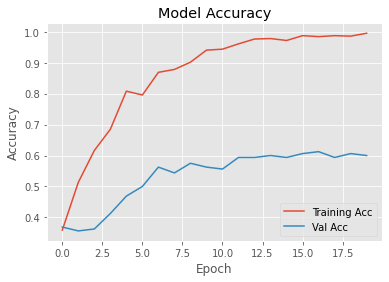

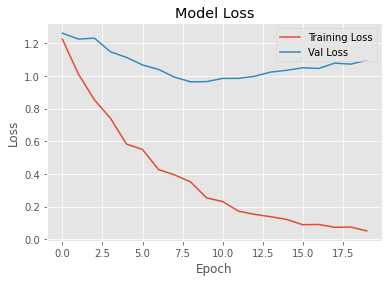

In [21]:
plt.style.use("ggplot")
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training Acc', 'Val Acc'], loc='lower right')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Loss', 'Val Loss'], loc='upper right')
plt.show()

In [22]:
filename = test_generator.filenames
truth = test_generator.classes
label = test_generator.class_indices
indexlabel = dict((value, key) for key, value in label.items())

predicts = model.predict_generator(test_generator, steps=test_generator.samples/test_generator.batch_size, verbose=1)
predict_class = np.argmax(predicts, axis=1)
errors = np.where(predict_class != truth)[0]
print("No of errors = {}/{}".format(len(errors),test_generator.samples))

10/10 [==============================] - 6s 527ms/step
No of errors = 66/164


Confusion Matrix
[[35  9 11]
 [19 35  0]
 [20  7 28]]


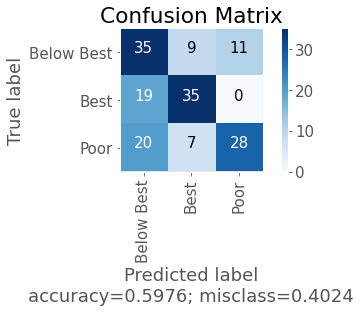

<Figure size 2160x2160 with 0 Axes>

In [23]:
from sklearn import preprocessing
plt.rcParams["axes.grid"] = False
plt.rcParams.update({'font.size': 15})

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(truth,predict_class)

labels = []
for k,v in indexlabel.items():
    labels.append(v)
    
import itertools
def plot_confusion_matrix(cm, classes,normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion Matrix')

    print(cm)
#     fig = plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass)) 
    plt.figure(figsize=(30,30))


plot_confusion_matrix(cm, classes=labels,
                      title='Confusion Matrix')

In [24]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
y_pred = predicts
y_pred_probabilities=y_pred

y_pred = np.argmax(y_pred,axis = 1) 
y_actual = test_generator.classes

classnames=[]
for classname in test_generator.class_indices:
    classnames.append(classname)
target_names = classnames
print(classification_report(y_actual, y_pred, target_names=target_names))

              precision    recall  f1-score   support

  Below Best       0.47      0.64      0.54        55
        Best       0.69      0.65      0.67        54
        Poor       0.72      0.51      0.60        55

    accuracy                           0.60       164
   macro avg       0.63      0.60      0.60       164
weighted avg       0.63      0.60      0.60       164



## **VGG16**

In [25]:
from keras.applications.vgg16 import VGG16
from keras.models import Sequential
model = Sequential()

model.add(VGG16(weights = "imagenet", include_top=False, pooling = 'avg'))
model.add(Dropout(rate=0.5))
model.add(Dense(units=output_classes, activation='softmax'))
adam_opt = Adam(lr=1e-5, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=1e-5)

model.layers[0].trainable = True

58900480/58889256 [==============================] - 0s 0us/step


In [26]:
model.compile(optimizer= adam_opt,
              loss = 'categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 512)               14714688  
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 1539      
Total params: 14,716,227
Trainable params: 14,716,227
Non-trainable params: 0
_________________________________________________________________


In [27]:
history = model.fit_generator(
  train_generator,
  steps_per_epoch = nb_train_samples // batch_size,
  epochs = epochs,
  validation_data = test_generator,
  validation_steps = nb_test_samples // batch_size)

Epoch 1/20
41/41 [==============================] - 31s 614ms/step - loss: 1.1952 - accuracy: 0.3838 - val_loss: 1.0308 - val_accuracy: 0.5250
Epoch 2/20
41/41 [==============================] - 23s 563ms/step - loss: 1.0115 - accuracy: 0.4945 - val_loss: 1.0439 - val_accuracy: 0.5562
Epoch 3/20
41/41 [==============================] - 24s 574ms/step - loss: 0.8204 - accuracy: 0.6162 - val_loss: 0.9626 - val_accuracy: 0.5250
Epoch 4/20
41/41 [==============================] - 24s 572ms/step - loss: 0.7307 - accuracy: 0.6599 - val_loss: 1.0349 - val_accuracy: 0.5188
Epoch 5/20
41/41 [==============================] - 23s 568ms/step - loss: 0.6348 - accuracy: 0.7239 - val_loss: 0.8089 - val_accuracy: 0.6250
Epoch 6/20
41/41 [==============================] - 23s 571ms/step - loss: 0.5415 - accuracy: 0.7816 - val_loss: 0.8577 - val_accuracy: 0.6313
Epoch 7/20
41/41 [==============================] - 23s 567ms/step - loss: 0.4872 - accuracy: 0.7972 - val_loss: 0.9518 - val_accuracy: 0.6125

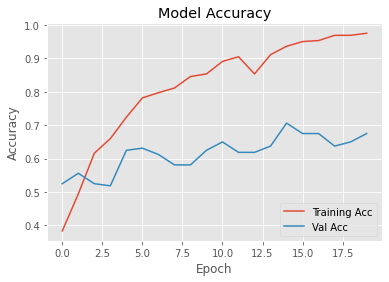

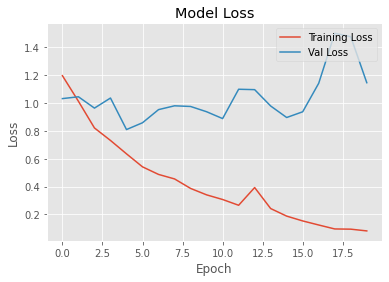

In [28]:
plt.style.use("ggplot")
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training Acc', 'Val Acc'], loc='lower right')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Loss', 'Val Loss'], loc='upper right')
plt.show()

In [29]:
filename = test_generator.filenames
truth = test_generator.classes
label = test_generator.class_indices
indexlabel = dict((value, key) for key, value in label.items())

predicts = model.predict_generator(test_generator, steps=test_generator.samples/test_generator.batch_size, verbose=1)
predict_class = np.argmax(predicts, axis=1)
errors = np.where(predict_class != truth)[0]
print("No of errors = {}/{}".format(len(errors),test_generator.samples))

10/10 [==============================] - 6s 580ms/step
No of errors = 55/164


Confusion Matrix
[[40  9  6]
 [15 39  0]
 [17  8 30]]


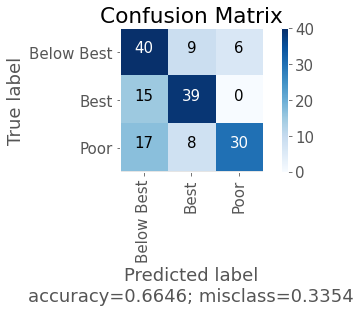

<Figure size 2160x2160 with 0 Axes>

In [30]:
from sklearn import preprocessing
plt.rcParams["axes.grid"] = False
plt.rcParams.update({'font.size': 15})

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(truth,predict_class)

labels = []
for k,v in indexlabel.items():
    labels.append(v)
    
import itertools
def plot_confusion_matrix(cm, classes,normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion Matrix')

    print(cm)
#     fig = plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass)) 
    plt.figure(figsize=(30,30))


plot_confusion_matrix(cm, classes=labels,
                      title='Confusion Matrix')

In [31]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
y_pred = predicts
y_pred_probabilities=y_pred

y_pred = np.argmax(y_pred,axis = 1) 
y_actual = test_generator.classes

classnames=[]
for classname in test_generator.class_indices:
    classnames.append(classname)
target_names = classnames
print(classification_report(y_actual, y_pred, target_names=target_names))

              precision    recall  f1-score   support

  Below Best       0.56      0.73      0.63        55
        Best       0.70      0.72      0.71        54
        Poor       0.83      0.55      0.66        55

    accuracy                           0.66       164
   macro avg       0.70      0.66      0.67       164
weighted avg       0.70      0.66      0.67       164



### **Xception**

In [32]:
from keras.applications.xception import Xception, preprocess_input
adam_opt = Adam(lr=1e-5, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=1e-5)
model = Sequential()

model.add(Xception(weights = "imagenet", include_top=False, pooling = 'avg'))
model.add(Dropout(rate=0.5))
model.add(Dense(units=output_classes, activation='softmax'))

model.layers[0].trainable = True

83697664/83683744 [==============================] - 1s 0us/step


In [33]:
model.compile(optimizer= adam_opt,
              loss = 'categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Functional)        (None, 2048)              20861480  
_________________________________________________________________
dropout_2 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 6147      
Total params: 20,867,627
Trainable params: 20,813,099
Non-trainable params: 54,528
_________________________________________________________________


In [34]:
history = model.fit_generator(
  train_generator,
  steps_per_epoch = nb_train_samples // batch_size,
  epochs = epochs,
  validation_data = test_generator,
  validation_steps = nb_test_samples // batch_size)

Epoch 1/20
41/41 [==============================] - 32s 652ms/step - loss: 1.1322 - accuracy: 0.3541 - val_loss: 1.2497 - val_accuracy: 0.3562
Epoch 2/20
41/41 [==============================] - 25s 610ms/step - loss: 1.0491 - accuracy: 0.4758 - val_loss: 1.1715 - val_accuracy: 0.3625
Epoch 3/20
41/41 [==============================] - 25s 614ms/step - loss: 0.9719 - accuracy: 0.5320 - val_loss: 1.1184 - val_accuracy: 0.3875
Epoch 4/20
41/41 [==============================] - 25s 607ms/step - loss: 0.8906 - accuracy: 0.6334 - val_loss: 1.0719 - val_accuracy: 0.3875
Epoch 5/20
41/41 [==============================] - 25s 609ms/step - loss: 0.8092 - accuracy: 0.6927 - val_loss: 1.0406 - val_accuracy: 0.4375
Epoch 6/20
41/41 [==============================] - 25s 605ms/step - loss: 0.7340 - accuracy: 0.7535 - val_loss: 0.9989 - val_accuracy: 0.4938
Epoch 7/20
41/41 [==============================] - 25s 604ms/step - loss: 0.6405 - accuracy: 0.8128 - val_loss: 0.9659 - val_accuracy: 0.5250

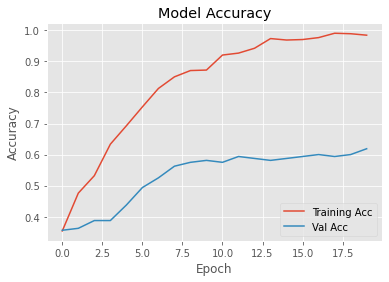

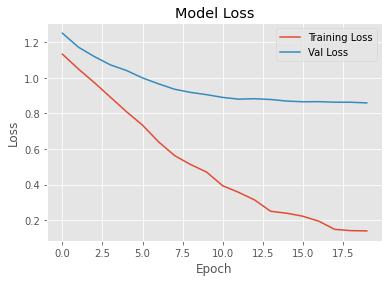

In [35]:
plt.style.use("ggplot")
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training Acc', 'Val Acc'], loc='lower right')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Loss', 'Val Loss'], loc='upper right')
plt.show()

In [36]:
filename = test_generator.filenames
truth = test_generator.classes
label = test_generator.class_indices
indexlabel = dict((value, key) for key, value in label.items())

predicts = model.predict_generator(test_generator, steps=test_generator.samples/test_generator.batch_size, verbose=1)
predict_class = np.argmax(predicts, axis=1)
errors = np.where(predict_class != truth)[0]
print("No of errors = {}/{}".format(len(errors),test_generator.samples))

10/10 [==============================] - 6s 504ms/step
No of errors = 63/164


Confusion Matrix
[[39 12  4]
 [19 34  1]
 [18  9 28]]


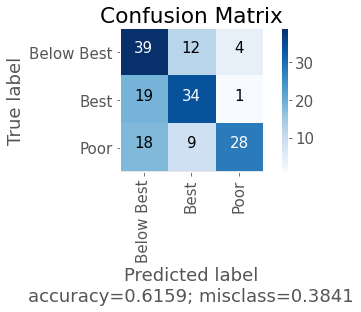

<Figure size 2160x2160 with 0 Axes>

In [37]:
from sklearn import preprocessing
plt.rcParams["axes.grid"] = False
plt.rcParams.update({'font.size': 15})

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(truth,predict_class)

labels = []
for k,v in indexlabel.items():
    labels.append(v)
    
import itertools
def plot_confusion_matrix(cm, classes,normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion Matrix')

    print(cm)
#     fig = plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass)) 
    plt.figure(figsize=(30,30))


plot_confusion_matrix(cm, classes=labels,
                      title='Confusion Matrix')

In [38]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
y_pred = predicts
y_pred_probabilities=y_pred

y_pred = np.argmax(y_pred,axis = 1) 
y_actual = test_generator.classes

classnames=[]
for classname in test_generator.class_indices:
    classnames.append(classname)
target_names = classnames
print(classification_report(y_actual, y_pred, target_names=target_names))

              precision    recall  f1-score   support

  Below Best       0.51      0.71      0.60        55
        Best       0.62      0.63      0.62        54
        Poor       0.85      0.51      0.64        55

    accuracy                           0.62       164
   macro avg       0.66      0.62      0.62       164
weighted avg       0.66      0.62      0.62       164



### **VGG19**

In [39]:
from keras.applications.vgg19 import VGG19
adam_opt = Adam(lr=1e-5, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=1e-5)
model = Sequential()

model.add(VGG19(weights = "imagenet", include_top=False, pooling = 'avg'))
model.add(Dropout(rate=0.5))
model.add(Dense(units=output_classes, activation='softmax'))

model.layers[0].trainable = True

80150528/80134624 [==============================] - 0s 0us/step


In [40]:
model.compile(optimizer= adam_opt,
              loss = 'categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 512)               20024384  
_________________________________________________________________
dropout_3 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 1539      
Total params: 20,025,923
Trainable params: 20,025,923
Non-trainable params: 0
_________________________________________________________________


In [41]:
history = model.fit_generator(
  train_generator,
  steps_per_epoch = nb_train_samples // batch_size,
  epochs = epochs,
  validation_data = test_generator,
  validation_steps = nb_test_samples // batch_size)

Epoch 1/20
41/41 [==============================] - 26s 605ms/step - loss: 1.2431 - accuracy: 0.3760 - val_loss: 1.0407 - val_accuracy: 0.5000
Epoch 2/20
41/41 [==============================] - 24s 588ms/step - loss: 1.0221 - accuracy: 0.5023 - val_loss: 1.0148 - val_accuracy: 0.4875
Epoch 3/20
41/41 [==============================] - 24s 595ms/step - loss: 0.8606 - accuracy: 0.6162 - val_loss: 1.0288 - val_accuracy: 0.4875
Epoch 4/20
41/41 [==============================] - 24s 585ms/step - loss: 0.7835 - accuracy: 0.6225 - val_loss: 0.8464 - val_accuracy: 0.6313
Epoch 5/20
41/41 [==============================] - 24s 594ms/step - loss: 0.6667 - accuracy: 0.7239 - val_loss: 0.7979 - val_accuracy: 0.6375
Epoch 6/20
41/41 [==============================] - 24s 589ms/step - loss: 0.5926 - accuracy: 0.7566 - val_loss: 0.9145 - val_accuracy: 0.5437
Epoch 7/20
41/41 [==============================] - 24s 586ms/step - loss: 0.4884 - accuracy: 0.8019 - val_loss: 0.9161 - val_accuracy: 0.6375

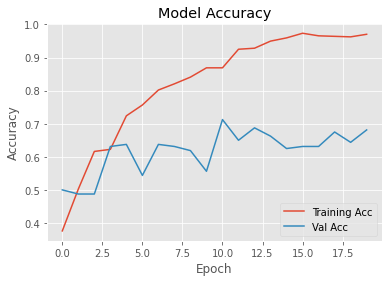

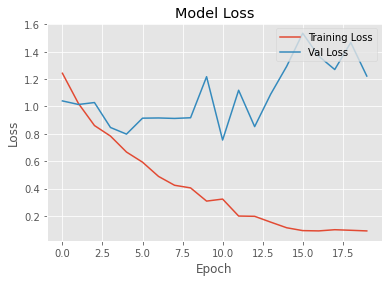

In [42]:
plt.style.use("ggplot")
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training Acc', 'Val Acc'], loc='lower right')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Loss', 'Val Loss'], loc='upper right')
plt.show()

In [43]:
filename = test_generator.filenames
truth = test_generator.classes
label = test_generator.class_indices
indexlabel = dict((value, key) for key, value in label.items())

predicts = model.predict_generator(test_generator, steps=test_generator.samples/test_generator.batch_size, verbose=1)
predict_class = np.argmax(predicts, axis=1)
errors = np.where(predict_class != truth)[0]
print("No of errors = {}/{}".format(len(errors),test_generator.samples))

10/10 [==============================] - 5s 442ms/step
No of errors = 54/164


Confusion Matrix
[[38  7 10]
 [11 40  3]
 [17  6 32]]


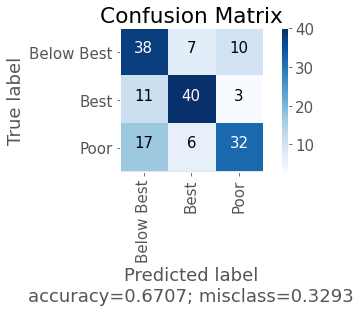

<Figure size 2160x2160 with 0 Axes>

In [44]:
from sklearn import preprocessing
plt.rcParams["axes.grid"] = False
plt.rcParams.update({'font.size': 15})

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(truth,predict_class)

labels = []
for k,v in indexlabel.items():
    labels.append(v)
    
import itertools
def plot_confusion_matrix(cm, classes,normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion Matrix')

    print(cm)
#     fig = plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass)) 
    plt.figure(figsize=(30,30))


plot_confusion_matrix(cm, classes=labels,
                      title='Confusion Matrix')

In [45]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
y_pred = predicts
y_pred_probabilities=y_pred

y_pred = np.argmax(y_pred,axis = 1) 
y_actual = test_generator.classes

classnames=[]
for classname in test_generator.class_indices:
    classnames.append(classname)
target_names = classnames
print(classification_report(y_actual, y_pred, target_names=target_names))

              precision    recall  f1-score   support

  Below Best       0.58      0.69      0.63        55
        Best       0.75      0.74      0.75        54
        Poor       0.71      0.58      0.64        55

    accuracy                           0.67       164
   macro avg       0.68      0.67      0.67       164
weighted avg       0.68      0.67      0.67       164



### **ResNet50**

In [47]:
from keras.applications.resnet import ResNet50
adam_opt = Adam(lr=1e-5, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=1e-5)
model = Sequential()

model.add(ResNet50(weights = "imagenet", include_top=False, pooling = 'avg'))
model.add(Dropout(rate=0.5))
model.add(Dense(units=output_classes, activation='softmax'))

model.layers[0].trainable = True

94781440/94765736 [==============================] - 0s 0us/step


In [48]:
model.compile(optimizer= adam_opt,
              loss = 'categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 2048)              23587712  
_________________________________________________________________
dropout_4 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 3)                 6147      
Total params: 23,593,859
Trainable params: 23,540,739
Non-trainable params: 53,120
_________________________________________________________________


In [49]:
history = model.fit_generator(
  train_generator,
  steps_per_epoch = nb_train_samples // batch_size,
  epochs = epochs,
  validation_data = test_generator,
  validation_steps = nb_test_samples // batch_size)

Epoch 1/20
41/41 [==============================] - 31s 600ms/step - loss: 1.3438 - accuracy: 0.3838 - val_loss: 1.1864 - val_accuracy: 0.3187
Epoch 2/20
41/41 [==============================] - 24s 575ms/step - loss: 0.8691 - accuracy: 0.6209 - val_loss: 1.4569 - val_accuracy: 0.3187
Epoch 3/20
41/41 [==============================] - 24s 569ms/step - loss: 0.6887 - accuracy: 0.6989 - val_loss: 1.5792 - val_accuracy: 0.3187
Epoch 4/20
41/41 [==============================] - 24s 578ms/step - loss: 0.5939 - accuracy: 0.7426 - val_loss: 1.7723 - val_accuracy: 0.3187
Epoch 5/20
41/41 [==============================] - 24s 578ms/step - loss: 0.4280 - accuracy: 0.8424 - val_loss: 1.9017 - val_accuracy: 0.3187
Epoch 6/20
41/41 [==============================] - 23s 572ms/step - loss: 0.3451 - accuracy: 0.8705 - val_loss: 2.0849 - val_accuracy: 0.3187
Epoch 7/20
41/41 [==============================] - 23s 572ms/step - loss: 0.3030 - accuracy: 0.8955 - val_loss: 2.2715 - val_accuracy: 0.3187

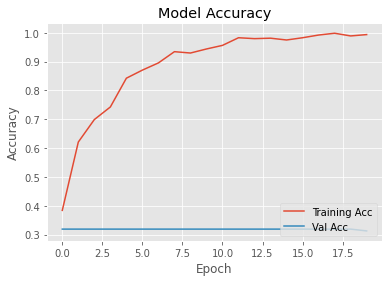

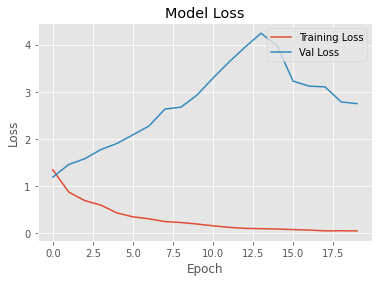

In [50]:
plt.style.use("ggplot")
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training Acc', 'Val Acc'], loc='lower right')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Loss', 'Val Loss'], loc='upper right')
plt.show()

In [51]:
filename = test_generator.filenames
truth = test_generator.classes
label = test_generator.class_indices
indexlabel = dict((value, key) for key, value in label.items())

predicts = model.predict_generator(test_generator, steps=test_generator.samples/test_generator.batch_size, verbose=1)
predict_class = np.argmax(predicts, axis=1)
errors = np.where(predict_class != truth)[0]
print("No of errors = {}/{}".format(len(errors),test_generator.samples))

10/10 [==============================] - 6s 496ms/step
No of errors = 110/164


Confusion Matrix
[[ 0  0 55]
 [ 1  0 53]
 [ 0  1 54]]


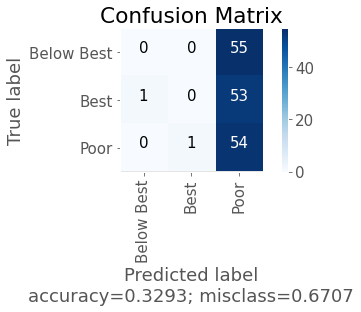

<Figure size 2160x2160 with 0 Axes>

In [52]:
from sklearn import preprocessing
plt.rcParams["axes.grid"] = False
plt.rcParams.update({'font.size': 15})

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(truth,predict_class)

labels = []
for k,v in indexlabel.items():
    labels.append(v)
    
import itertools
def plot_confusion_matrix(cm, classes,normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion Matrix')

    print(cm)
#     fig = plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass)) 
    plt.figure(figsize=(30,30))


plot_confusion_matrix(cm, classes=labels,
                      title='Confusion Matrix')

In [53]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
y_pred = predicts
y_pred_probabilities=y_pred

y_pred = np.argmax(y_pred,axis = 1) 
y_actual = test_generator.classes

classnames=[]
for classname in test_generator.class_indices:
    classnames.append(classname)
target_names = classnames
print(classification_report(y_actual, y_pred, target_names=target_names))

              precision    recall  f1-score   support

  Below Best       0.00      0.00      0.00        55
        Best       0.00      0.00      0.00        54
        Poor       0.33      0.98      0.50        55

    accuracy                           0.33       164
   macro avg       0.11      0.33      0.17       164
weighted avg       0.11      0.33      0.17       164



### **DenseNet201**

In [54]:
from keras.applications.densenet import DenseNet201
adam_opt = Adam(lr=1e-5, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=1e-5)
model = Sequential()

model.add(DenseNet201(weights = "imagenet", include_top=False, pooling = 'avg'))
model.add(Dropout(rate=0.5))
model.add(Dense(units=output_classes, activation='softmax'))

model.layers[0].trainable = True

74850304/74836368 [==============================] - 1s 0us/step


In [55]:
model.compile(optimizer= adam_opt,
              loss = 'categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet201 (Functional)     (None, 1920)              18321984  
_________________________________________________________________
dropout_5 (Dropout)          (None, 1920)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 3)                 5763      
Total params: 18,327,747
Trainable params: 18,098,691
Non-trainable params: 229,056
_________________________________________________________________


In [56]:
history = model.fit_generator(
  train_generator,
  steps_per_epoch = nb_train_samples // batch_size,
  epochs = epochs,
  validation_data = test_generator,
  validation_steps = nb_test_samples // batch_size)

Epoch 1/20
41/41 [==============================] - 52s 752ms/step - loss: 1.2690 - accuracy: 0.4197 - val_loss: 1.1600 - val_accuracy: 0.3688
Epoch 2/20
41/41 [==============================] - 25s 615ms/step - loss: 0.8525 - accuracy: 0.6069 - val_loss: 1.0954 - val_accuracy: 0.4500
Epoch 3/20
41/41 [==============================] - 25s 611ms/step - loss: 0.6873 - accuracy: 0.7114 - val_loss: 1.0370 - val_accuracy: 0.4875
Epoch 4/20
41/41 [==============================] - 25s 616ms/step - loss: 0.5527 - accuracy: 0.7722 - val_loss: 0.9930 - val_accuracy: 0.5125
Epoch 5/20
41/41 [==============================] - 25s 612ms/step - loss: 0.4237 - accuracy: 0.8315 - val_loss: 0.9757 - val_accuracy: 0.5312
Epoch 6/20
41/41 [==============================] - 25s 609ms/step - loss: 0.3442 - accuracy: 0.8752 - val_loss: 0.9480 - val_accuracy: 0.5562
Epoch 7/20
41/41 [==============================] - 25s 612ms/step - loss: 0.2977 - accuracy: 0.8924 - val_loss: 0.9271 - val_accuracy: 0.5813

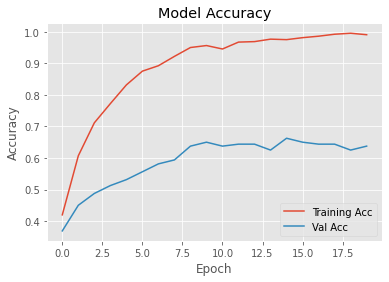

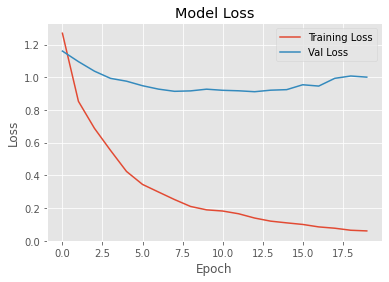

In [57]:
plt.style.use("ggplot")
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training Acc', 'Val Acc'], loc='lower right')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Loss', 'Val Loss'], loc='upper right')
plt.show()

In [58]:
filename = test_generator.filenames
truth = test_generator.classes
label = test_generator.class_indices
indexlabel = dict((value, key) for key, value in label.items())

predicts = model.predict_generator(test_generator, steps=test_generator.samples/test_generator.batch_size, verbose=1)
predict_class = np.argmax(predicts, axis=1)
errors = np.where(predict_class != truth)[0]
print("No of errors = {}/{}".format(len(errors),test_generator.samples))

10/10 [==============================] - 9s 649ms/step
No of errors = 60/164


Confusion Matrix
[[38 11  6]
 [17 36  1]
 [22  3 30]]


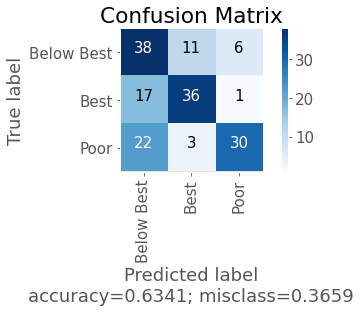

<Figure size 2160x2160 with 0 Axes>

In [59]:
from sklearn import preprocessing
plt.rcParams["axes.grid"] = False
plt.rcParams.update({'font.size': 15})

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(truth,predict_class)

labels = []
for k,v in indexlabel.items():
    labels.append(v)
    
import itertools
def plot_confusion_matrix(cm, classes,normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion Matrix')

    print(cm)
#     fig = plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass)) 
    plt.figure(figsize=(30,30))


plot_confusion_matrix(cm, classes=labels,
                      title='Confusion Matrix')

In [60]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
y_pred = predicts
y_pred_probabilities=y_pred

y_pred = np.argmax(y_pred,axis = 1) 
y_actual = test_generator.classes

classnames=[]
for classname in test_generator.class_indices:
    classnames.append(classname)
target_names = classnames
print(classification_report(y_actual, y_pred, target_names=target_names))

              precision    recall  f1-score   support

  Below Best       0.49      0.69      0.58        55
        Best       0.72      0.67      0.69        54
        Poor       0.81      0.55      0.65        55

    accuracy                           0.63       164
   macro avg       0.67      0.63      0.64       164
weighted avg       0.67      0.63      0.64       164

